# EMNIST using linear + softmax classfier
The EMNIST dataset is a set of handwritten character digits derived from the NIST Special Database 19 and converted to a 28x28 pixel image format and dataset structure that directly matches the MNIST dataset. Further information on the dataset contents and conversion process can be found in the paper available at https://arxiv.org/abs/1702.05373v1.

Dataset is available at https://www.kaggle.com/crawford/emnist

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

## reading
read data from csv file

In [2]:
train_data_filename = 'emnist-balanced-train.csv'
test_data_filename = 'emnist-balanced-test.csv'
# train_data_filename = 'mnist_train.csv'
# test_data_filename = 'mnist_test.csv'
raw_train_data = np.genfromtxt('EMNIST_data/' + train_data_filename, delimiter=',')
raw_test_data = np.genfromtxt('EMNIST_data/' + test_data_filename, delimiter=',')
print('loaded', train_data_filename,'with size', raw_train_data.shape)
print('loaded', test_data_filename,'with size', raw_test_data.shape)

loaded emnist-balanced-train.csv with size (112800, 785)
loaded emnist-balanced-test.csv with size (18800, 785)


read mapping file

In [3]:
mapping_filename = 'EMNIST_data/emnist-balanced-mapping.txt'
mapper = {}
with open(mapping_filename) as f:
    m = map(str.split, f.readlines())
    for item in m:
        mapper.update({int(item[0]): chr(int(item[1]))})
print(mapper)

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z', 36: 'a', 37: 'b', 38: 'd', 39: 'e', 40: 'f', 41: 'g', 42: 'h', 43: 'n', 44: 'q', 45: 'r', 46: 't'}


## loading
load data into numpy

In [4]:
classes = 47
eye = np.eye(classes)
train_images, train_labels = raw_train_data[:, 1:], eye[raw_train_data[:, :1].astype(int).ravel()]
test_images, test_labels = raw_test_data[:, 1:], eye[raw_test_data[:, :1].astype(int).ravel()]
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(112800, 784)
(112800, 47)
(18800, 784)
(18800, 47)


## data visiualization

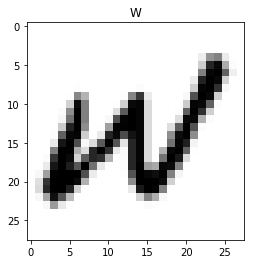

In [5]:
index = 69
img = train_images[index].reshape(28,28).T
plt.imshow(img,cmap='binary')
plt.title(mapper[np.argmax(train_labels[index])])
plt.show()

data normalization

In [6]:
train_images/=255.0
test_images/=255.0

## modeling
create a simple linear model classifier

In [7]:
x = tf.placeholder("float", [None, 784])
W = tf.Variable(tf.zeros([784,classes]))
b = tf.Variable(tf.zeros([classes]))
y = tf.matmul(x, W) + b
y_hat = tf.nn.softmax(y)

<font color='red'>To ensure numeric stability, standard cross entropy formula should not be used.</font>

see also https://stackoverflow.com/questions/33712178/tensorflow-nan-bug

In [8]:
y_ = tf.placeholder("float", [None,classes])
# cross_entropy = -tf.reduce_sum(y_*tf.log(y))
cross_entropy = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
train_step = tf.train.AdamOptimizer().minimize(cross_entropy)

## training
using batch gradient decsent to train the model with 10000 iterations

0 171451.2573928833
1 134236.21466827393
2 129432.27337646484
3 127100.83416748047
4 125572.55219268799
5 124442.1243057251
6 123615.85669708252
7 122777.53383636475
8 122251.02639770508
9 121717.35615539551
10 121148.40774536133
11 120711.19705200195
12 120295.42079162598
13 119923.76140213013
14 119621.77390670776
15 119237.07572937012
16 119012.99369812012
17 118695.33736801147
18 118398.25563812256
19 118202.27767562866


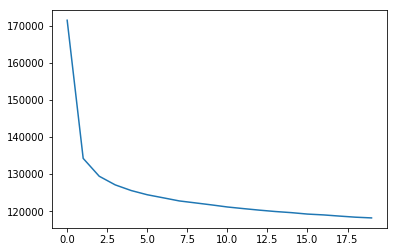

In [9]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
batch_size = 100
costs = []
for epoch in range(20):
    cost = 0
    p = np.arange(train_images.shape[0])
    np.random.shuffle(p)
    batch_length = np.ceil(train_images.shape[0] / batch_size).astype(int)
    for i in range(batch_length):
        d1 = i * batch_size
        d2 = min(d1 + batch_size, train_images.shape[0])
        d = sess.run([train_step, cross_entropy], feed_dict={
            x: train_images[p[d1 : d2]], 
            y_: train_labels[p[d1 : d2]]
        })
        cost += d[1]
    print(epoch, cost)
    costs.append(cost)
plt.plot(costs)

## evaluating

In [10]:
print('weight:', b.eval())
correct_prediction = tf.equal(tf.argmax(y_hat,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print('training set accuracy:', sess.run(accuracy, feed_dict={x: train_images, y_: train_labels}))
print('test set accuracy:', sess.run(accuracy, feed_dict={x: test_images, y_: test_labels}))

weight: [-0.46801797  1.6041654  -0.0746531  -1.0026678   0.43959576  0.8996554
 -1.4896535   0.62788725 -2.059856   -0.5340411  -0.8039992  -2.303359
  0.8253285  -0.533347   -1.5678512   0.73055995 -1.0097618  -0.2880731
  1.2516983   3.0874743  -0.02512194  3.369176   -1.0865295   0.01988337
 -0.70619583 -0.22233893 -1.5580502  -1.6394224   0.10038937  1.6003567
  0.00728364  1.0431854  -1.44778    -1.0397129   1.9608598  -0.4698665
 -0.7740277  -0.33684525 -0.31649178 -1.2584271   0.12507544 -1.087031
  1.8534896   0.61121637 -1.308061    1.0674881   2.1525686 ]
training set accuracy: 0.72074467
test set accuracy: 0.6921809


## result visiualization

Model predicts N


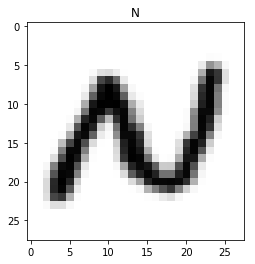

In [11]:
index = 8140
img = test_images[index].reshape(28,28).T
plt.imshow(img,cmap='binary')
plt.title(mapper[np.argmax(test_labels[index])])
prediction = tf.argmax(y, 1)
print('Model predicts', mapper[prediction.eval(feed_dict={x: test_images[index].reshape(1,784)})[0]])